In [ ]:
# Install FEniCS
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

<div class="alert alert-danger">
<font size="5"><strong>Heat conduction - Thermal diffusion</strong></font>
</div>



<div class="alert alert-warning">
<font size="4"><strong>MATHEMATICAL FORMULATION: </strong></font>
</div>

Consider the stationray heat equation:

\begin{eqnarray*}
 \text{ div }\mathbf{q}  =  f &      \text{ in } \Omega,
\end{eqnarray*}

where $\mathbf{q}$ is the heat flux and $f$ denotes a heat source within the domain $\Omega$.

The thermal material is described by the following linear Fourier Law:

$$
\mathbf{q} = -\mathbf k \mathbf{\nabla} T
$$

where $u$ is the temperature and $\mathbf k$ is thermal conductivity; in the simple case of thermally isotropic material, $\mathbf k = k \mathbf I$ with $k$ the isotropic thermal conductivity. The thermal conductivity may very well depend on the temperature  itself. This will then result in a nonlinear heat equation.

**For the case of an isotropic and homogeneous body, the heat equation specializes as follows**

\begin{eqnarray*}
- k \Delta T  =  f &      \text{ in } \Omega,
\end{eqnarray*}

**where $\Delta$ is the standard Laplace operator.**

Equation (7) is completed by proper boundary conditions. For simplicity, we consider the boundary value problem, that is,
$$
\left\{
\begin{array}{ll}
T = T_0 & \text{ on }  \Gamma_D, \\
k \nabla T \cdot {\bf n} = g & \text{ on }  \Gamma_N.
\end{array}
\right.$$

Here, $\Gamma_D \subset \partial \Omega$ denotes the part of the boundary where we prescribe Dirichlet boundary conditions and $\Gamma_N \subset \partial \Omega$ denotes the part of the boundary where we prescribe Neumann boundary conditions. $\bf{n}$ denotes the unit normal of $\partial \Omega$ pointing outside $\Omega$.


<div class="alert alert-warning">
<font size="4"><strong>Weak formulation: </strong></font>
</div>

Let us define the spaces $V_{T_0}, V_0 \in \Omega$ as

$$ V_{T_0} := \left\{ v \in H^1(\Omega) \text{ s. t. } v = T_0 \text{ on } \Gamma_D \right\},$$

$$ V_{0} := \left\{ v \in H^1(\Omega) \text{ s. t. } v = 0 \text{ on } \Gamma_D \right\}.$$

To obtain the weak formulation, we multiply the PDE by an arbitrary function $v \in V_0$ and integrate over the domain $\Omega$ leading to

$$ -\int_{\Omega} \nabla \cdot (k \nabla T) v \, dx = \int_\Omega f v \, dx\quad \forall \; v \in V_0. $$

Then, integration by parts the non-conforming term gives

$$ \int_{\Omega} k \nabla T \cdot \nabla v \, dx - \int_{\partial \Omega} k \frac{\partial T}{\partial {\bf n} } v \, ds = \int_\Omega f v \, dx \quad \forall \; v \in V_0. $$

Finally by recalling that $ v = 0 $ on $\Gamma_D$ and that $k \frac{\partial T}{\partial {\bf n} } = g $ on $\Gamma_N$, we find the weak formulation:

*Find  $T \in V_{T_0}$ such that*
$$ \int_{\Omega} k \nabla T \cdot \nabla v \, dx = \int_\Omega f v \, dx + \int_{\Gamma_N} g v \, ds \quad \forall \; v \in V_0. $$

<div class="alert alert-warning">
<font size="5"><strong>Solving a PDE in FEniCS
: </strong></font>
</div>

<div class="alert alert-warning">
<font size="4"><strong>Concrete example:
</strong></font>
</div>

Next, we need to specify $\{ {T_0},f,\Omega \}$. We choose a simple 2D domain: the unit square $\Omega = [0,1] \times [0,1]$ .

Here
\begin{eqnarray*}
k(x,y) = 1  & \text{ on } \Omega\\
f(x,y) = \left(4\pi^2+\frac{\pi^2}{4}\right)\sin(2 \pi x) \sin\left(\frac{\pi}{2} y\right) & \text{ on } \Omega\\
T_0(x,y)      = 0 & \text{ on } \Gamma_D, \\
g(x) = \left\{ \begin{array}{l} -\frac{\pi}{2}\sin(2 \pi x) \\ 0 \end{array}\right.
& \begin{array}{l} \text{ on } \Gamma_{\rm bottom},\\ \text{ on } \Gamma_{\rm top}.\end{array}
\end{eqnarray*}

### 1. Imports

We import the following Python packages:

In [ ]:
from dolfin import *
import matplotlib.pyplot as plt

# to plot the result in the Notebook
%matplotlib inline

### 2. Generating a mesh and define the finite element space

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_3801828c0f66b7190a7fd5819465b3d5b34b9149

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00504565 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.335393 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representation
INFO:FFC:----------------------------

dim(Vh) =  121


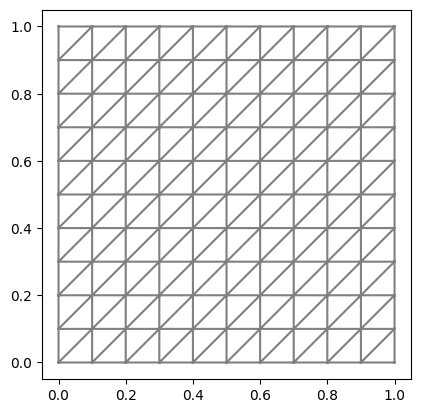

In [ ]:
from mshr import *
n = 10
d = 1
mesh = RectangleMesh(Point(0, 0), Point(1, 1), n, n)
plot(mesh)

Vh  = FunctionSpace(mesh, 'Lagrange', d)
print ("dim(Vh) = ", Vh.dim())

### 3. Setting problem parameters

In [ ]:
k = Constant(1.)

u_L = Constant(0.)
u_R = Constant(0.)

g_bottom = Expression('-(pi/2.0)*sin(2*pi*x[0])', degree=d+2)
g_top    = Expression('0', degree=0)

f = Expression('(4.0*pi*pi+pi*pi/4.0)*(sin(2*pi*x[0])*sin((pi/2.0)*x[1]))', degree=d+2)

### 4. Define boundary labels

To partition the boundary of $\Omega$ in the subdomains $\Gamma_{\rm top}$, $\Gamma_{\rm bottom}$, $\Gamma_{\rm left}$, $\Gamma_{\rm right}$ we assign a unique label `boundary_parts` to each of part of $\partial \Omega$. We use a **class** of **SubDomain** to identify the various parts of the mesh function.

In order to apply boundary conditions, we must mark the different parts of the boundary correctly. and mark these as subdomains  1, 2, 3 and 4, respectively.

In [ ]:
DOLFIN_EPS

3e-16

In [ ]:
mesh.topology().dim()

2

In [ ]:
# Define the Top part of the boundary
class TopBoundary(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and abs(x[1] - 1) < DOLFIN_EPS
# Define the Bottom part of the boundary
class BottomBoundary(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and abs(x[1]) < DOLFIN_EPS
# Define the Left part of the boundary
class LeftBoundary(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and abs(x[0]) < DOLFIN_EPS
# Define the Right part of the boundary
class RightBoundary(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and abs(x[0] - 1) < DOLFIN_EPS

boundary_parts = MeshFunction("size_t", mesh, mesh.topology().dim()-1, 0)

# mark the entire boundary as 0

boundary_parts.set_all(0)

# Mark the boundaries as subdomains  1, 2, 3 and 4

Gamma_top = TopBoundary()
Gamma_top.mark(boundary_parts, 1)

Gamma_bottom = BottomBoundary()
Gamma_bottom.mark(boundary_parts, 2)

Gamma_left = LeftBoundary()
Gamma_left.mark(boundary_parts, 3)

Gamma_right = RightBoundary()
Gamma_right.mark(boundary_parts, 4)

### 5. Defining boundary conditions

In order to apply boundary conditions, we must mark the different parts of the boundary correctly.
In FEniCS, we create a new boundary measure `ds[i]` to integrate over the portion of the boundary marked with label `i`.

In [ ]:
# Define Dirichlet boundary condition
bcs = [DirichletBC(Vh, u_L, boundary_parts, 3),
       DirichletBC(Vh, u_R, boundary_parts, 4)]
# Define the integration on boundary
ds = Measure("ds", domain=mesh, subdomain_data=boundary_parts)

### 6. Defining the variational problem

In [ ]:
u = TrialFunction(Vh)
v = TestFunction(Vh)
a = inner(nabla_grad(u), nabla_grad(v))*dx  # bilinear part
L = f*v*dx + g_top*v*ds(1) + g_bottom*v*ds(2) # linear part (top and bottom)

uh = Function(Vh)

### 7. Solving the linear system

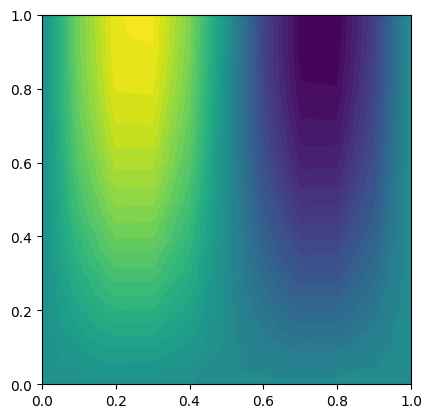

In [ ]:
uh = Function(Vh)
# solve(a == L, uh, bcs=bcs)
A, b = assemble_system(a,L, bcs=bcs)
solve(A, uh.vector(), b, "cg")

plot(uh)

#  Exercise 1

Modify the previous code to solve the following the boundary value problem:

\begin{eqnarray*}
-  \text{ div }(\mathbf k \mathbf{\nabla} u)  = f, &      \text{ in } &\Omega,   \tag{1}\\
u = u_0, & \text{ on } & \Gamma_D = \Gamma_{left} \cup \Gamma_{right}, \tag{2}\\
\frac{\partial u}{\partial {n}} = g, & \text{ on } &\Gamma_N = \Gamma_{top} \cup \Gamma_{bottom} , \tag{3}
\end{eqnarray*}

with
$$
\Omega = (0,1)^2,
$$

\begin{eqnarray*}
{\mathbf k}(x,y) = \bigg( \begin{array}{l} 2 & 1 \\ 1  & 2\end{array} \bigg ),
\end{eqnarray*}

$$ f(x, y) = 10 e^{-((x - 0.5)^2 + (y - 0.5)^2) / 0.02} $$
$$
u_\mathrm{0}(x, y) = 0,
$$
\begin{eqnarray*}
g(x, y) = sin(5x).
\end{eqnarray*}

The following script can be used to implement the thermal conductivity:
```
#
# Define thermal conductivity
#
k = as_matrix([[2.0 , 1.0] , [1.0 , 2.0]])
#
# Define variational problem
#
v = TestFunction(V)
u = TrialFunction(V)
a = inner(A*grad(u), grad(v))*dx
```

### Solution

## Discretization error

In FEniCS, it is easy to perform some error analysis.

We can therefore compute the following norm of the discretization error (i.e. the of the difference between the finite element solution $u_h$ and the exact solution $u_{\rm ex}$)
$$ \| u_{\rm ex} - u_h \|_{L^2{(\Omega})} := \sqrt{ \int_{\Omega} (u_{\rm ex} - u_h)^2 \, dx }. $$

### **Example:** Discretization error for Poisson equation

We set up the following Poisson problem:

$$
- \Delta u = f ,       \text{ in } \Omega = [0,1]\times[0,1], \\
   u = u_{ex},   \text{ on } \partial \Omega,
$$

where
$$u_{ex} = e^{-100.0((x - 0.03)^2 + (y - 0.03)^2)} + e^{-1000.0((x - 1.0)^2 + (y - 1.0)^2)}$$

is the exact solution. Inserting $u_{ex}$ into the  PDE gives $f$.

$$
f (x,y) = (400.0 - 40000.0((x - 0.03)^2 + (y - 0.03)^2))e^{-100.0((x - 0.03)^2 + (y - 0.03)^2)} + (4000.0 - 4000000.0((x - 1.0)^2 + (y - 1.0)^2)) e^{-1000.0((x - 1.0)^2 + (y - 1.0)^2)}
$$

In [ ]:
from dolfin import *
import matplotlib.pyplot as plt

# to plot the result in the Notebook
%matplotlib inline
#
#  Create a triangular mesh on the unit square.
#
N=10
my_mesh = UnitSquareMesh ( N, N )
#
#  Define the function space.
#
V = FunctionSpace ( my_mesh, 'P', 1 )
#
#  Define the exact solution using an expression:
#
ue = Expression('exp(-100.0*((x[0] - 0.03)*(x[0] - 0.03) + (x[1] - 0.03)*(x[1] - 0.03))) + exp(-1000.0*((x[0] - 1.0)*(x[0] - 1.0) + (x[1] - 1.0)*(x[1] - 1.0)))', degree = 4 )
#
#  Use the expression to define the boundary condition.
#
def boundary ( x, on_boundary ):
    return on_boundary

bc = DirichletBC ( V, ue, boundary )
#
#  Define the variational problem.
#
u = TrialFunction ( V )
v = TestFunction ( V )
#
f = Expression ( '(400.0 - 40000.0*((x[0] - 0.03)*(x[0] - 0.03) + (x[1] - 0.03)*(x[1] - 0.03)))*exp(-100.0*((x[0] - 0.03)*(x[0] - 0.03) + (x[1] - 0.03)*(x[1] - 0.03))) + (4000.0 - 4000000.0*((x[0] - 1.0)*(x[0] - 1.0) + (x[1] - 1.0)*(x[1] - 1.0)))*exp(-1000.0*((x[0] - 1.0)*(x[0] - 1.0) + (x[1] - 1.0)*(x[1] - 1.0)))', degree = 4 )
#
a = dot ( grad ( u ), grad ( v ) ) * dx
L = f * v * dx
#
#  Compute the solution.
#
uh = Function ( V )
solve ( a == L, uh, bc )
#
#  Use the expression to compute the error in the L2 norm.
#
error_L2 = errornorm ( ue, uh, 'L2' )
print ( '  error_L2  =', error_L2 )

# H1 seminorm
error_H1 = errornorm(ue, uh, 'H10')
print ( '  error_H1  =', error_H1 )
#
#  Use the expression to compute the maximum error at mesh vertices.
#
vertex_values_u_exact_expr = ue.compute_vertex_values ( my_mesh )
vertex_values_uh = uh.compute_vertex_values ( my_mesh )
import numpy as np
error_max = np.max ( np.abs ( vertex_values_u_exact_expr - vertex_values_uh ) )
print ( '  error_max =', error_max )

  error_L2  = 0.03799355834011879
  error_H1  = 1.2284131556919424
  error_max = 0.07421773974248858
